In [1]:
import numpy as np
def get_data():
    data_file = "tdaily_cet.dat.txt"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(' ')
            temperatures.append(float(linedata[1]))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")
    return time, series

In [2]:
time, series = get_data()
print(len(series))

91502


In [3]:
# Create Sliding Windows on the data series
import torch

def create_sliding_windows_with_target(data, window_size, shift=1):
    """
    Creates sliding windows from a sequence, splitting each window into features and target.

    Args:
        data: Input sequence (can be list, numpy array, or torch tensor)
        window_size: Size of each window
        shift: Number of elements to shift each window (stride)

    Returns:
        tuple: (features, targets) where:
            - features is a tensor of shape (num_windows, window_size-1)
            - targets is a tensor of shape (num_windows, 1)
    """
    # Convert input to tensor if it isn't already
    if not isinstance(data, torch.Tensor):
        data = torch.tensor(data, dtype=torch.float32)

    # Create windows using unfold
    windows = data.unfold(0, window_size, shift)

    # Split each window into features (all but last element) and target (last element)
    features = windows[:, :-1]  # All elements except the last
    targets = windows[:, -1:]   # Just the last element

    return features, targets


In [4]:
import numpy as np

def normalize_series(data, missing_value=999.9):
    # Convert to numpy array if not already
    data = np.array(data, dtype=np.float64)

    # Create mask for valid values (not NaN and not missing_value)
    valid_mask = (data != missing_value) & (~np.isnan(data))

    # Keep only valid values
    clean_data = data[valid_mask]

    # Normalize using only valid values
    mean = np.mean(clean_data)
    std = np.std(clean_data)
    normalized = (clean_data - mean) / std

    return normalized


time, series = get_data()
series_normalized = normalize_series(series)


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Subset
import numpy as np

# First create the full windowed dataset
series_tensor = torch.tensor(series_normalized, dtype=torch.float32)
window_size = 60
features, targets = create_sliding_windows_with_target(series_tensor, window_size=window_size, shift=1)

In [6]:
split_location = 80000

features = features.unsqueeze(1)
# Create the full dataset
full_dataset = TensorDataset(features, targets)

# Calculate split indices
# Note: Since we're using windows, we need to account for the overlap
train_size = split_location - window_size + 1  # Adjust for window overlap
total_windows = len(full_dataset)
train_indices = list(range(train_size))
val_indices = list(range(train_size, total_windows))

# Create training and validation datasets using Subset
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)



In [7]:
# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print information about the splits
print(f"Original series length: {len(series_normalized)}")
print(f"Total number of windows: {total_windows}")
print(f"Training windows: {len(train_dataset)}")
print(f"Validation windows: {len(val_dataset)}")

# Show example batch from each
print("\nExample Training Batch:")
train_features, train_targets = next(iter(train_loader))
print(f"Batch shape - Features: {train_features.shape}, Targets: {train_targets.shape}")

print("\nExample Validation Batch:")
val_features, val_targets = next(iter(val_loader))
print(f"Batch shape - Features: {val_features.shape}, Targets: {val_targets.shape}")

Original series length: 91502
Total number of windows: 91443
Training windows: 79941
Validation windows: 11502

Example Training Batch:
Batch shape - Features: torch.Size([128, 1, 59]), Targets: torch.Size([128, 1])

Example Validation Batch:
Batch shape - Features: torch.Size([128, 1, 59]), Targets: torch.Size([128, 1])


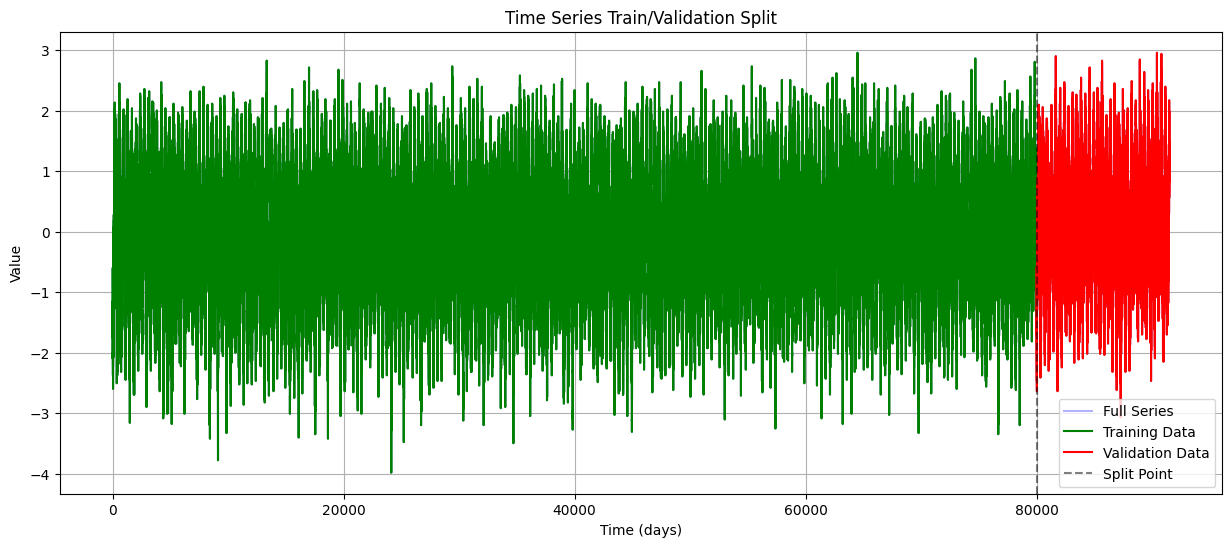

In [8]:
# Visualize the split point
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(range(len(series_normalized)), series_normalized, 'b-', label='Full Series', alpha=0.3)
plt.plot(range(split_location), series_normalized[:split_location], 'g-', label='Training Data')
plt.plot(range(split_location, len(series_normalized)), series_normalized[split_location:], 'r-', label='Validation Data')
plt.axvline(x=split_location, color='k', linestyle='--', alpha=0.5, label='Split Point')
plt.title('Time Series Train/Validation Split')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import torch.nn as nn
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, dropout_rate=0.3):
        super(SimpleRNNModel, self).__init__()

        self.rnn1 = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          batch_first=True,
                          dropout=dropout_rate)  # Add dropout to RNN

        self.rnn2 = nn.GRU(input_size=hidden_size,
                          hidden_size=hidden_size,
                          batch_first=True,
                          dropout=dropout_rate)  # Add dropout to RNN

        # Add more layers before final output
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out1, _ = self.rnn1(x)
        out2, _ = self.rnn2(out1)
        last_out = out2[:, -1, :]
        output = self.linear(last_out)
        return output



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
Epoch 1/100: 100%|██████████| 625/625 [00:04<00:00, 151.12it/s]


Epoch 1/100
Training Loss: 0.147625
Validation Loss: 0.099458
----------------------------------------


Epoch 2/100: 100%|██████████| 625/625 [00:03<00:00, 200.75it/s]


Epoch 2/100
Training Loss: 0.113656
Validation Loss: 0.095373
----------------------------------------


Epoch 3/100: 100%|██████████| 625/625 [00:03<00:00, 200.76it/s]


Epoch 3/100
Training Loss: 0.113093
Validation Loss: 0.096422
----------------------------------------


Epoch 4/100: 100%|██████████| 625/625 [00:03<00:00, 166.46it/s]


Epoch 4/100
Training Loss: 0.112010
Validation Loss: 0.093772
----------------------------------------


Epoch 5/100: 100%|██████████| 625/625 [00:03<00:00, 189.13it/s]


Epoch 5/100
Training Loss: 0.112308
Validation Loss: 0.095737
----------------------------------------


Epoch 6/100: 100%|██████████| 625/625 [00:03<00:00, 201.88it/s]


Epoch 6/100
Training Loss: 0.111574
Validation Loss: 0.095705
----------------------------------------


Epoch 7/100: 100%|██████████| 625/625 [00:03<00:00, 196.86it/s]


Epoch 7/100
Training Loss: 0.111297
Validation Loss: 0.092481
----------------------------------------


Epoch 8/100: 100%|██████████| 625/625 [00:04<00:00, 154.72it/s]


Epoch 8/100
Training Loss: 0.111201
Validation Loss: 0.094666
----------------------------------------


Epoch 9/100: 100%|██████████| 625/625 [00:03<00:00, 199.38it/s]


Epoch 9/100
Training Loss: 0.110955
Validation Loss: 0.095823
----------------------------------------


Epoch 10/100: 100%|██████████| 625/625 [00:03<00:00, 183.94it/s]


Epoch 10/100
Training Loss: 0.110822
Validation Loss: 0.096060
----------------------------------------


Epoch 11/100: 100%|██████████| 625/625 [00:04<00:00, 138.61it/s]


Epoch 11/100
Training Loss: 0.110417
Validation Loss: 0.093904
----------------------------------------


Epoch 12/100: 100%|██████████| 625/625 [00:03<00:00, 192.45it/s]


Epoch 12/100
Training Loss: 0.110625
Validation Loss: 0.093245
----------------------------------------


Epoch 13/100: 100%|██████████| 625/625 [00:03<00:00, 202.29it/s]


Epoch 13/100
Training Loss: 0.110497
Validation Loss: 0.098615
----------------------------------------


Epoch 14/100: 100%|██████████| 625/625 [00:03<00:00, 196.62it/s]


Epoch 14/100
Training Loss: 0.110230
Validation Loss: 0.092416
----------------------------------------


Epoch 15/100: 100%|██████████| 625/625 [00:04<00:00, 149.82it/s]


Epoch 15/100
Training Loss: 0.110220
Validation Loss: 0.093415
----------------------------------------


Epoch 16/100: 100%|██████████| 625/625 [00:03<00:00, 201.58it/s]


Epoch 16/100
Training Loss: 0.110237
Validation Loss: 0.092651
----------------------------------------


Epoch 17/100: 100%|██████████| 625/625 [00:03<00:00, 198.65it/s]


Epoch 17/100
Training Loss: 0.109881
Validation Loss: 0.095175
----------------------------------------


Epoch 18/100: 100%|██████████| 625/625 [00:03<00:00, 171.50it/s]


Epoch 18/100
Training Loss: 0.109578
Validation Loss: 0.092929
----------------------------------------


Epoch 19/100: 100%|██████████| 625/625 [00:03<00:00, 178.70it/s]


Epoch 19/100
Training Loss: 0.109758
Validation Loss: 0.092427
----------------------------------------


Epoch 20/100: 100%|██████████| 625/625 [00:03<00:00, 200.86it/s]


Epoch 20/100
Training Loss: 0.109551
Validation Loss: 0.092843
----------------------------------------


Epoch 21/100: 100%|██████████| 625/625 [00:03<00:00, 203.53it/s]


Epoch 21/100
Training Loss: 0.109751
Validation Loss: 0.091866
----------------------------------------


Epoch 22/100: 100%|██████████| 625/625 [00:03<00:00, 157.51it/s]


Epoch 22/100
Training Loss: 0.109530
Validation Loss: 0.096093
----------------------------------------


Epoch 23/100: 100%|██████████| 625/625 [00:03<00:00, 201.59it/s]


Epoch 23/100
Training Loss: 0.109245
Validation Loss: 0.093835
----------------------------------------


Epoch 24/100: 100%|██████████| 625/625 [00:03<00:00, 202.34it/s]


Epoch 24/100
Training Loss: 0.108899
Validation Loss: 0.093770
----------------------------------------


Epoch 25/100: 100%|██████████| 625/625 [00:03<00:00, 190.03it/s]


Epoch 25/100
Training Loss: 0.108736
Validation Loss: 0.091731
----------------------------------------


Epoch 26/100: 100%|██████████| 625/625 [00:03<00:00, 168.71it/s]


Epoch 26/100
Training Loss: 0.108331
Validation Loss: 0.095970
----------------------------------------


Epoch 27/100: 100%|██████████| 625/625 [00:03<00:00, 202.78it/s]


Epoch 27/100
Training Loss: 0.108067
Validation Loss: 0.092848
----------------------------------------


Epoch 28/100: 100%|██████████| 625/625 [00:03<00:00, 199.50it/s]


Epoch 28/100
Training Loss: 0.108317
Validation Loss: 0.095745
----------------------------------------


Epoch 29/100: 100%|██████████| 625/625 [00:04<00:00, 154.35it/s]


Epoch 29/100
Training Loss: 0.108182
Validation Loss: 0.094204
----------------------------------------


Epoch 30/100: 100%|██████████| 625/625 [00:03<00:00, 201.80it/s]


Epoch 30/100
Training Loss: 0.107984
Validation Loss: 0.092325
----------------------------------------


Epoch 31/100: 100%|██████████| 625/625 [00:03<00:00, 197.39it/s]


Epoch 31/100
Training Loss: 0.107681
Validation Loss: 0.094905
----------------------------------------


Epoch 32/100: 100%|██████████| 625/625 [00:03<00:00, 195.45it/s]


Epoch 32/100
Training Loss: 0.107753
Validation Loss: 0.093020
----------------------------------------


Epoch 33/100: 100%|██████████| 625/625 [00:04<00:00, 154.48it/s]


Epoch 33/100
Training Loss: 0.107252
Validation Loss: 0.093356
----------------------------------------


Epoch 34/100: 100%|██████████| 625/625 [00:03<00:00, 197.85it/s]


Epoch 34/100
Training Loss: 0.106893
Validation Loss: 0.093645
----------------------------------------


Epoch 35/100: 100%|██████████| 625/625 [00:03<00:00, 204.81it/s]


Epoch 35/100
Training Loss: 0.106583
Validation Loss: 0.096269
----------------------------------------


Epoch 36/100: 100%|██████████| 625/625 [00:03<00:00, 165.67it/s]


Epoch 36/100
Training Loss: 0.106493
Validation Loss: 0.093762
----------------------------------------


Epoch 37/100: 100%|██████████| 625/625 [00:03<00:00, 192.43it/s]


Epoch 37/100
Training Loss: 0.106762
Validation Loss: 0.092817
----------------------------------------


Epoch 38/100: 100%|██████████| 625/625 [00:03<00:00, 202.47it/s]


Epoch 38/100
Training Loss: 0.106094
Validation Loss: 0.094917
----------------------------------------


Epoch 39/100: 100%|██████████| 625/625 [00:03<00:00, 201.50it/s]


Epoch 39/100
Training Loss: 0.105496
Validation Loss: 0.097562
----------------------------------------


Epoch 40/100: 100%|██████████| 625/625 [00:04<00:00, 151.43it/s]


Epoch 40/100
Training Loss: 0.105764
Validation Loss: 0.095413
----------------------------------------


Epoch 41/100: 100%|██████████| 625/625 [00:03<00:00, 202.20it/s]


Epoch 41/100
Training Loss: 0.105243
Validation Loss: 0.093492
----------------------------------------


Epoch 42/100: 100%|██████████| 625/625 [00:03<00:00, 205.20it/s]


Epoch 42/100
Training Loss: 0.105251
Validation Loss: 0.095660
----------------------------------------


Epoch 43/100: 100%|██████████| 625/625 [00:03<00:00, 186.72it/s]


Epoch 43/100
Training Loss: 0.104748
Validation Loss: 0.098006
----------------------------------------


Epoch 44/100: 100%|██████████| 625/625 [00:03<00:00, 168.90it/s]


Epoch 44/100
Training Loss: 0.104287
Validation Loss: 0.094207
----------------------------------------


Epoch 45/100: 100%|██████████| 625/625 [00:03<00:00, 204.05it/s]


Epoch 45/100
Training Loss: 0.104049
Validation Loss: 0.097075
----------------------------------------


Epoch 46/100: 100%|██████████| 625/625 [00:03<00:00, 201.23it/s]


Epoch 46/100
Training Loss: 0.103416
Validation Loss: 0.097335
----------------------------------------


Epoch 47/100: 100%|██████████| 625/625 [00:03<00:00, 160.91it/s]


Epoch 47/100
Training Loss: 0.103075
Validation Loss: 0.095628
----------------------------------------


Epoch 48/100: 100%|██████████| 625/625 [00:03<00:00, 203.43it/s]


Epoch 48/100
Training Loss: 0.102600
Validation Loss: 0.094889
----------------------------------------


Epoch 49/100: 100%|██████████| 625/625 [00:03<00:00, 198.94it/s]


Epoch 49/100
Training Loss: 0.102318
Validation Loss: 0.096318
----------------------------------------


Epoch 50/100: 100%|██████████| 625/625 [00:03<00:00, 203.22it/s]


Epoch 50/100
Training Loss: 0.101624
Validation Loss: 0.094678
----------------------------------------


Epoch 51/100: 100%|██████████| 625/625 [00:04<00:00, 151.58it/s]


Epoch 51/100
Training Loss: 0.101245
Validation Loss: 0.098093
----------------------------------------


Epoch 52/100: 100%|██████████| 625/625 [00:03<00:00, 202.67it/s]


Epoch 52/100
Training Loss: 0.100436
Validation Loss: 0.097887
----------------------------------------


Epoch 53/100: 100%|██████████| 625/625 [00:03<00:00, 201.55it/s]


Epoch 53/100
Training Loss: 0.100661
Validation Loss: 0.098254
----------------------------------------


Epoch 54/100: 100%|██████████| 625/625 [00:03<00:00, 167.80it/s]


Epoch 54/100
Training Loss: 0.100165
Validation Loss: 0.096615
----------------------------------------


Epoch 55/100: 100%|██████████| 625/625 [00:03<00:00, 182.02it/s]


Epoch 55/100
Training Loss: 0.098909
Validation Loss: 0.098053
----------------------------------------


Epoch 56/100: 100%|██████████| 625/625 [00:03<00:00, 203.79it/s]


Epoch 56/100
Training Loss: 0.098541
Validation Loss: 0.098807
----------------------------------------


Epoch 57/100: 100%|██████████| 625/625 [00:03<00:00, 197.56it/s]


Epoch 57/100
Training Loss: 0.098350
Validation Loss: 0.099194
----------------------------------------


Epoch 58/100: 100%|██████████| 625/625 [00:04<00:00, 152.79it/s]


Epoch 58/100
Training Loss: 0.097632
Validation Loss: 0.099160
----------------------------------------


Epoch 59/100: 100%|██████████| 625/625 [00:03<00:00, 202.18it/s]


Epoch 59/100
Training Loss: 0.096745
Validation Loss: 0.098412
----------------------------------------


Epoch 60/100: 100%|██████████| 625/625 [00:03<00:00, 196.24it/s]


Epoch 60/100
Training Loss: 0.096127
Validation Loss: 0.103565
----------------------------------------


Epoch 61/100: 100%|██████████| 625/625 [00:03<00:00, 177.73it/s]


Epoch 61/100
Training Loss: 0.095294
Validation Loss: 0.101934
----------------------------------------


Epoch 62/100: 100%|██████████| 625/625 [00:03<00:00, 171.65it/s]


Epoch 62/100
Training Loss: 0.095053
Validation Loss: 0.100907
----------------------------------------


Epoch 63/100: 100%|██████████| 625/625 [00:03<00:00, 195.26it/s]


Epoch 63/100
Training Loss: 0.094020
Validation Loss: 0.101773
----------------------------------------


Epoch 64/100: 100%|██████████| 625/625 [00:03<00:00, 200.69it/s]


Epoch 64/100
Training Loss: 0.093835
Validation Loss: 0.100992
----------------------------------------


Epoch 65/100: 100%|██████████| 625/625 [00:04<00:00, 147.61it/s]


Epoch 65/100
Training Loss: 0.092679
Validation Loss: 0.101871
----------------------------------------


Epoch 66/100: 100%|██████████| 625/625 [00:03<00:00, 192.18it/s]


Epoch 66/100
Training Loss: 0.092341
Validation Loss: 0.102141
----------------------------------------


Epoch 67/100: 100%|██████████| 625/625 [00:03<00:00, 193.47it/s]


Epoch 67/100
Training Loss: 0.091242
Validation Loss: 0.104442
----------------------------------------


Epoch 68/100: 100%|██████████| 625/625 [00:03<00:00, 183.47it/s]


Epoch 68/100
Training Loss: 0.090737
Validation Loss: 0.104732
----------------------------------------


Epoch 69/100: 100%|██████████| 625/625 [00:03<00:00, 163.57it/s]


Epoch 69/100
Training Loss: 0.089992
Validation Loss: 0.104862
----------------------------------------


Epoch 70/100: 100%|██████████| 625/625 [00:03<00:00, 197.12it/s]


Epoch 70/100
Training Loss: 0.089070
Validation Loss: 0.103663
----------------------------------------


Epoch 71/100: 100%|██████████| 625/625 [00:03<00:00, 194.31it/s]


Epoch 71/100
Training Loss: 0.088359
Validation Loss: 0.105868
----------------------------------------


Epoch 72/100: 100%|██████████| 625/625 [00:04<00:00, 146.55it/s]


Epoch 72/100
Training Loss: 0.087602
Validation Loss: 0.105980
----------------------------------------


Epoch 73/100: 100%|██████████| 625/625 [00:03<00:00, 195.02it/s]


Epoch 73/100
Training Loss: 0.086729
Validation Loss: 0.106199
----------------------------------------


Epoch 74/100: 100%|██████████| 625/625 [00:03<00:00, 189.61it/s]


Epoch 74/100
Training Loss: 0.086064
Validation Loss: 0.107287
----------------------------------------


Epoch 75/100: 100%|██████████| 625/625 [00:03<00:00, 181.02it/s]


Epoch 75/100
Training Loss: 0.085568
Validation Loss: 0.107071
----------------------------------------


Epoch 76/100: 100%|██████████| 625/625 [00:03<00:00, 162.80it/s]


Epoch 76/100
Training Loss: 0.084262
Validation Loss: 0.108707
----------------------------------------


Epoch 77/100: 100%|██████████| 625/625 [00:03<00:00, 195.12it/s]


Epoch 77/100
Training Loss: 0.083572
Validation Loss: 0.106961
----------------------------------------


Epoch 78/100: 100%|██████████| 625/625 [00:03<00:00, 195.65it/s]


Epoch 78/100
Training Loss: 0.083091
Validation Loss: 0.110585
----------------------------------------


Epoch 79/100: 100%|██████████| 625/625 [00:04<00:00, 148.67it/s]


Epoch 79/100
Training Loss: 0.082118
Validation Loss: 0.109820
----------------------------------------


Epoch 80/100: 100%|██████████| 625/625 [00:03<00:00, 195.52it/s]


Epoch 80/100
Training Loss: 0.081203
Validation Loss: 0.109975
----------------------------------------


Epoch 81/100: 100%|██████████| 625/625 [00:03<00:00, 194.99it/s]


Epoch 81/100
Training Loss: 0.080379
Validation Loss: 0.111692
----------------------------------------


Epoch 82/100: 100%|██████████| 625/625 [00:03<00:00, 176.56it/s]


Epoch 82/100
Training Loss: 0.079306
Validation Loss: 0.111801
----------------------------------------


Epoch 83/100: 100%|██████████| 625/625 [00:03<00:00, 164.20it/s]


Epoch 83/100
Training Loss: 0.078708
Validation Loss: 0.111705
----------------------------------------


Epoch 84/100: 100%|██████████| 625/625 [00:03<00:00, 195.15it/s]


Epoch 84/100
Training Loss: 0.077813
Validation Loss: 0.112562
----------------------------------------


Epoch 85/100: 100%|██████████| 625/625 [00:03<00:00, 193.91it/s]


Epoch 85/100
Training Loss: 0.077075
Validation Loss: 0.116780
----------------------------------------


Epoch 86/100: 100%|██████████| 625/625 [00:04<00:00, 149.88it/s]


Epoch 86/100
Training Loss: 0.075980
Validation Loss: 0.114677
----------------------------------------


Epoch 87/100: 100%|██████████| 625/625 [00:03<00:00, 193.36it/s]


Epoch 87/100
Training Loss: 0.075598
Validation Loss: 0.116946
----------------------------------------


Epoch 88/100: 100%|██████████| 625/625 [00:03<00:00, 196.66it/s]


Epoch 88/100
Training Loss: 0.074737
Validation Loss: 0.118265
----------------------------------------


Epoch 89/100: 100%|██████████| 625/625 [00:03<00:00, 176.59it/s]


Epoch 89/100
Training Loss: 0.073660
Validation Loss: 0.116108
----------------------------------------


Epoch 90/100: 100%|██████████| 625/625 [00:03<00:00, 161.59it/s]


Epoch 90/100
Training Loss: 0.072904
Validation Loss: 0.117157
----------------------------------------


Epoch 91/100: 100%|██████████| 625/625 [00:03<00:00, 194.16it/s]


Epoch 91/100
Training Loss: 0.071994
Validation Loss: 0.117223
----------------------------------------


Epoch 92/100: 100%|██████████| 625/625 [00:03<00:00, 195.61it/s]


Epoch 92/100
Training Loss: 0.071322
Validation Loss: 0.119763
----------------------------------------


Epoch 93/100: 100%|██████████| 625/625 [00:04<00:00, 147.67it/s]


Epoch 93/100
Training Loss: 0.070491
Validation Loss: 0.122504
----------------------------------------


Epoch 94/100: 100%|██████████| 625/625 [00:03<00:00, 195.07it/s]


Epoch 94/100
Training Loss: 0.069725
Validation Loss: 0.119148
----------------------------------------


Epoch 95/100: 100%|██████████| 625/625 [00:03<00:00, 196.88it/s]


Epoch 95/100
Training Loss: 0.068830
Validation Loss: 0.124481
----------------------------------------


Epoch 96/100: 100%|██████████| 625/625 [00:03<00:00, 172.28it/s]


Epoch 96/100
Training Loss: 0.067958
Validation Loss: 0.122525
----------------------------------------


Epoch 97/100: 100%|██████████| 625/625 [00:03<00:00, 164.27it/s]


Epoch 97/100
Training Loss: 0.067402
Validation Loss: 0.121801
----------------------------------------


Epoch 98/100: 100%|██████████| 625/625 [00:03<00:00, 194.59it/s]


Epoch 98/100
Training Loss: 0.066538
Validation Loss: 0.124122
----------------------------------------


Epoch 99/100: 100%|██████████| 625/625 [00:03<00:00, 193.66it/s]


Epoch 99/100
Training Loss: 0.066078
Validation Loss: 0.125149
----------------------------------------


Epoch 100/100: 100%|██████████| 625/625 [00:04<00:00, 147.33it/s]


Epoch 100/100
Training Loss: 0.064945
Validation Loss: 0.124828
----------------------------------------


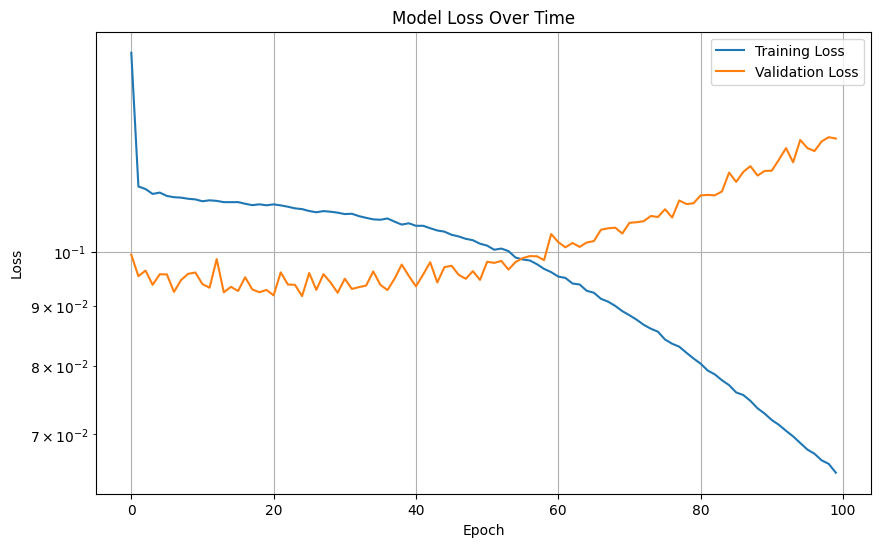

In [19]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.0005):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store metrics
    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {avg_train_loss:.6f}")
        print(f"Validation Loss: {avg_val_loss:.6f}")
        print("-" * 40)


    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Log scale often better for loss visualization
    plt.show()

    return train_losses, val_losses

# Example usage:
num_epochs = 100
learning_rate = 0.0005
dropout_rate = 0.1
hidden_size = 100

# Create the model
#model = SimpleRNNModel(input_size=window_size-1, dropout_rate=dropout_rate, hidden_size=hidden_size)
#model = SimpleLSTMModel(input_size=window_size-1, dropout_rate=dropout_rate, hidden_size=hidden_size)
model = BidirectionalGRUModel(input_size=window_size-1, dropout_rate=dropout_rate, hidden_size=hidden_size)

train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    learning_rate=learning_rate
)


Validation MAE: 0.2782


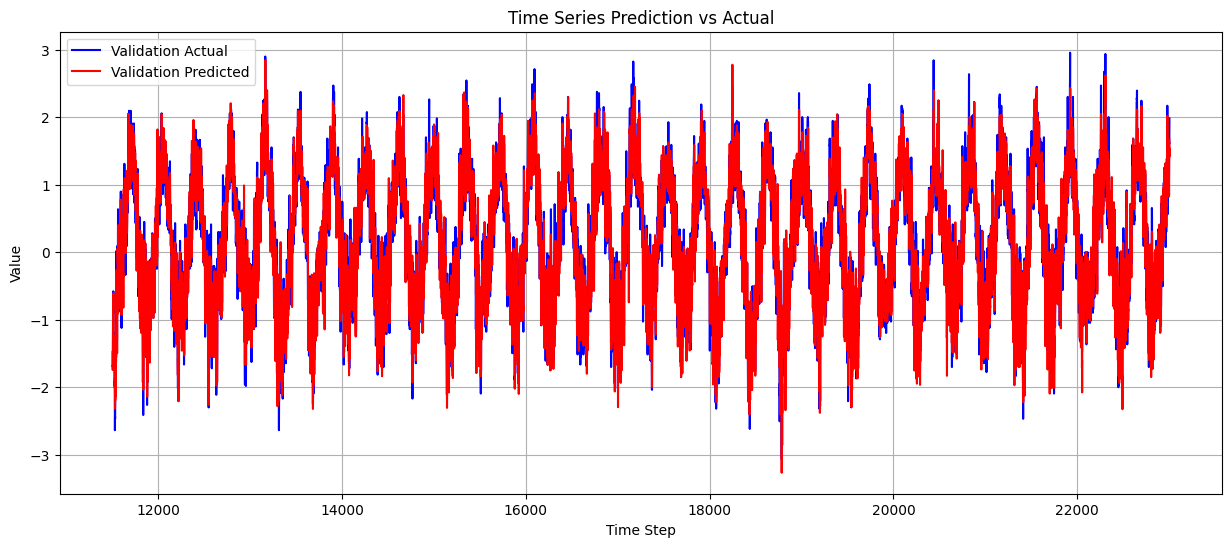

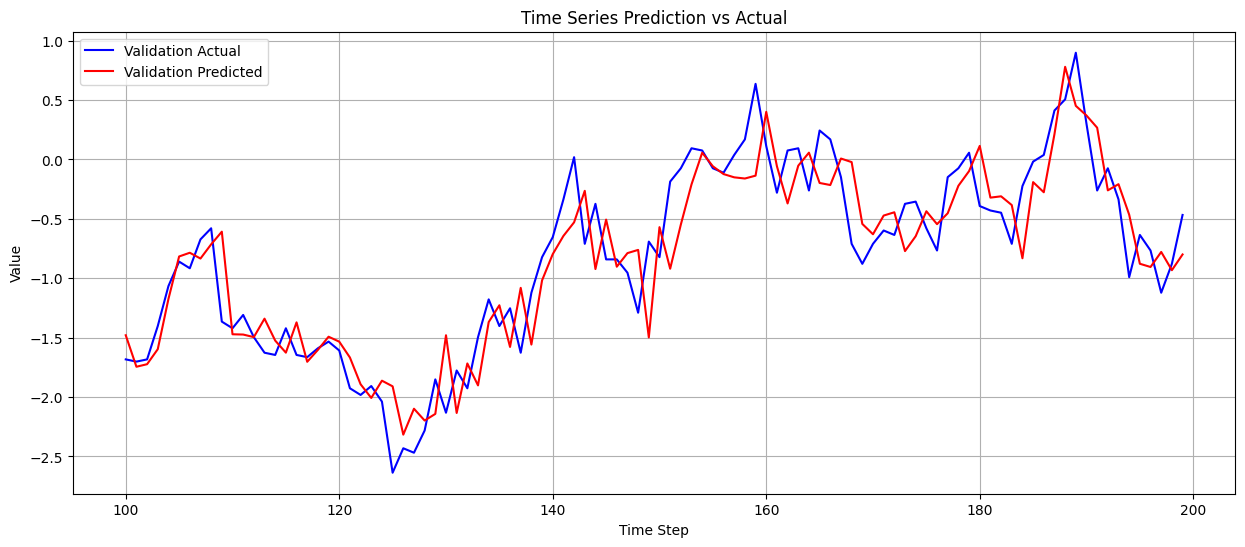

In [20]:
# Step 5 - Do predictions
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def evaluate_predictions(model, loader):
    """Generate predictions and calculate metrics"""
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    predictions = np.array(all_predictions)
    targets = np.array(all_targets)


    # Calculate metrics
    mae = mean_absolute_error(targets, predictions)

    return predictions, targets, mae

def plot_predictions(val_pred, val_true):
    """Plot the predictions against actual values"""
    plt.figure(figsize=(15, 6))


    # Plot validation data
    offset = len(val_true)
    plt.plot(range(offset, offset + len(val_true)), val_true, 'b-', label='Validation Actual')
    plt.plot(range(offset, offset + len(val_pred)), val_pred, 'r-', label='Validation Predicted')



    plt.title('Time Series Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# After training your model:
# Generate predictions
val_predictions, val_targets, val_mae = evaluate_predictions(model, val_loader)

# Print metrics
print(f"Validation MAE: {val_mae:.4f}")

# Plot results
plot_predictions(val_predictions, val_targets)
plot_predictions(val_predictions[:100], val_targets[:100])


In [30]:
print(len(val_predictions))

90702


In [14]:
# LSTM OPtional Archtiecture
import torch.nn as nn

class SimpleLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, dropout_rate=0.3):
        super(SimpleLSTMModel, self).__init__()

        self.lstm1 = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            batch_first=True,
                            dropout=dropout_rate)  # Add dropout to LSTM

        self.lstm2 = nn.LSTM(input_size=hidden_size,
                            hidden_size=hidden_size,
                            batch_first=True,
                            dropout=dropout_rate)  # Add dropout to LSTM

        # Add more layers before final output
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out1, _ = self.lstm1(x)  # LSTM returns (output, (h_n, c_n))
        out2, _ = self.lstm2(out1)  # We ignore both hidden and cell states with _
        last_out = out2[:, -1, :]
        output = self.linear(last_out)
        return output

In [18]:
class BidirectionalGRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, dropout_rate=0.1):
        super(BidirectionalGRUModel, self).__init__()

        self.gru1 = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          batch_first=True,
                          dropout=dropout_rate,
                          bidirectional=True)

        self.gru2 = nn.GRU(input_size=hidden_size * 2,
                          hidden_size=hidden_size,
                          batch_first=True,
                          dropout=dropout_rate,
                          bidirectional=True)

        # Additional layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out1, _ = self.gru1(x)
        out2, _ = self.gru2(out1)
        last_out = out2[:, -1, :]

        # Additional processing
        x = self.fc1(last_out)
        x = self.relu(x)
        x = self.dropout(x)
        output = self.linear(x)
        return output